## Prepare Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(21)

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import itertools
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set(style='white', context='notebook', palette='deep')

In [5]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

y_train = train_df['label']
X_train = train_df.drop(labels='label', axis=1)

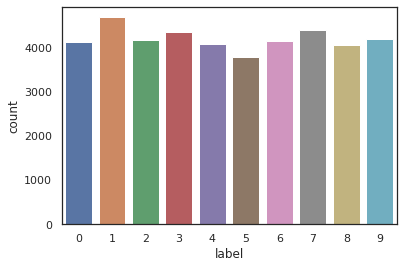

In [6]:
sns.countplot(y_train)

In [7]:
X_train = X_train / 255.0
test_df = test_df / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test_df = test_df.values.reshape(-1,28,28,1)

In [8]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=21)

In [10]:
X_train.shape

(37800, 28, 28, 1)

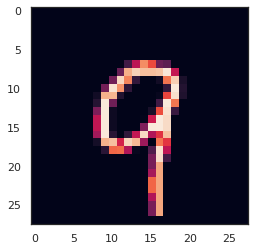

In [11]:
plt.imshow(X_train[0][:,:,0])

## CNN Modelling

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [17]:
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

## Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(X_train)

## Train and Test Model

In [25]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=86),
                              epochs=15, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 86,
                              callbacks=[lr_reduction])

Epoch 1/15
439/439 - 125s - loss: 0.0605 - accuracy: 0.9830 - val_loss: 0.0345 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 2/15
439/439 - 126s - loss: 0.0629 - accuracy: 0.9816 - val_loss: 0.0307 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 3/15
439/439 - 126s - loss: 0.0569 - accuracy: 0.9841 - val_loss: 0.0293 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 4/15
439/439 - 126s - loss: 0.0567 - accuracy: 0.9838 - val_loss: 0.0326 - val_accuracy: 0.9926 - lr: 0.0010
Epoch 5/15
439/439 - 126s - loss: 0.0589 - accuracy: 0.9841 - val_loss: 0.0340 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 6/15

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
439/439 - 126s - loss: 0.0611 - accuracy: 0.9835 - val_loss: 0.0304 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 7/15
439/439 - 125s - loss: 0.0454 - accuracy: 0.9873 - val_loss: 0.0276 - val_accuracy: 0.9950 - lr: 5.0000e-04
Epoch 8/15
439/439 - 125s - loss: 0.0439 - accuracy: 0.9873 - val_loss: 0.0265 - val_accuracy: 0.9950 - lr: 5.

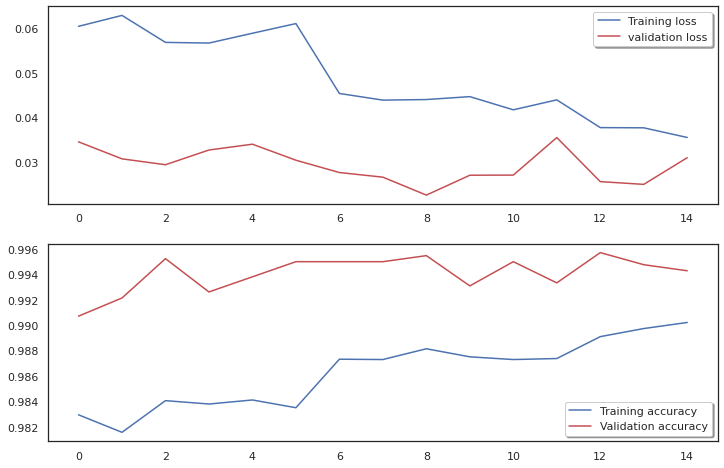

In [27]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)